# Simulare un problema di gravitazione

## 1. Moto dei pianeti in un campo gravitazionale fissato

È il caso più semplice, e pure quello affrontato da Keplero. Supporremo che il Sole sia fermo nella posizione (0,0,0), il centro del sistema solare, e che i pianeti si muovano nel potenziale gravitazionale generato dal Sole:

$$V(r) = -\frac{GM_\odot}{r}$$

o, equivalentemente, risentano nel punto $\boldsymbol{x}$ della forza gravitazionale:

$$\boldsymbol{F} = -\frac{GM_\odot \, m_p}{r^2}\boldsymbol{\hat{r}}$$

In altre parole, **trascuriamo l'influenza gravitazionale che i pianeti esercitano sul Sole**, e che lo fanno muovere attorno al baricentro del sistema, così come **trascuriamo l'influenza gravitazionale reciproca tra i pianeti**.


In [1]:
# Importiamo le principali librerie. numpy per usare i vettori e matplotlib.pyplot per generare i grafici

import autograd.numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

### Il problema delle unità di misura

Tutti i codici di simulazione di sistemi gravitazionali devono affrontare lo stesso problema iniziale: le grandezze in gioco sono o molto piccole ($G = $) oppure molto grandi ($M_\odot = $). Queste grandezze portano generano instabilità numeriche. 

La soluzione è quella di passare alle **unità interne**. Ridefiniamo noi delle unità di misura in modo tale che $G=1$ e che le masse si misurino in unità di masse solari ($1 \text{unità di massa}=1\, M_\odot$) e le lunghezze in unità astronomiche ($1 \text{unità di lunghezza}=1 \text{AU}$. L'unità astronomica è definita come la distanza Terra-Sole e vale 149 milioni di km) Può sembrare strano, ma è del tutto legittimo, purché tutte le altre unità di misura siano ridefinite coerentemente. 
Per esempio, se assumiamo queste unità di misura, come si ridefinisce l'unità di velocità e l'unità di tempo? 

Notiamo che la grandezza $\frac{GM}{rv^2}$ è adimensionale. Deve essere uguale sia che si esprima in cgs (o SI) sia che si esprima in unità interne

$$\frac{M_{ui}}{r_{ui}v_{ui}^2}=\frac{G_{cgs}M_{cgs}}{r_{cgs}v_{cgs}^2}$$

da cui: 


$$v_{ui}=\sqrt{\frac{r_{cgs}}{G_{cgs}M_{cgs}}}v_{cgs}$$

Un'altra grandezza adimensionale è $\frac{rt}{v}$. 

$$\frac{t_{ui}v_{ui}}{r_{ui}}=\frac{t_{cgs}v_{cgs}}{r_{cgs}}$$

$$t_{ui}=r_{ui}\sqrt{\frac{G_{cgs}M_{cgs}}{r_{cgs}^3}}t_{cgs}$$



In [2]:
G_cgs = 6.67259 * 10**-8         # G in cgs
M_sun = 1.9891 * 10**33          # massa solare in g
R_sun = 6.9598 * 10**10          # raggio solare in cm 
M_earth = 5.976 * 10**27         # massa della Terra in g
R_earth = 6.378 * 10**8          # raggio della Terra in cm
AU = 1.496 * 10**13              # AU in cm
km = 1.e5                        # 1 km in cm
hour = 3600                      # 1 ora in secondi
day = 86400                      # 1 giorno in secondi
yr = 3.156*10**7                 # 1 anno in secondi

# G = 1
# --- Unità interne: 1 massa solare è l'unità di massa, un AU è l'unità di distanza

# 1 km/s in UI è: 
km_s_in_IU = np.sqrt(AU/(G_cgs*M_sun)) * km
print("1 km/s in unità interne: ",km_s_in_IU)

# 1 giorno in UI è: 
day_IU = np.sqrt(G_cgs*M_sun/AU**3)*day
print("1 giorno in unità interne: ",day_IU)

# 1 anno in UI è: 
year_IU = np.sqrt(G_cgs*M_sun/AU**3)*yr
print("1 anno in unità interne: ",year_IU)


1 km/s in unità interne:  0.033573009081299426
1 giorno in unità interne:  0.01720251245735279
1 anno in unità interne:  6.283695522616366


# Inizializziamo la simulazione: massa su orbita circolare

Consideriamo la Terra. La sua distanza dal Sole, in unità interne, è 1 (la distanza Terra-Sole è l'unità astronomica).
La condizione fondamentale affinché la Terra orbiti su un'orbita perfettamente circolare è che la forza gravitazionale sia **completamente centripeta**: 
- $\boldsymbol{v} \perp \boldsymbol{F}$
- $\dfrac{v^2}{R} = \dfrac{GM_\odot}{R^2}$

Da cui la formula per la velocità circolare kepleriana: 
$$v_\text{c} = \sqrt{\dfrac{GM_\odot}{R}}$$

Un modo conveniente per esprimere la forza gravitazionale in coordinate cartesiane in forma vettoriale è:

$$\boldsymbol{F} = -\frac{GM_\odot \, m_p}{r^3}\boldsymbol{r}$$

il campo gravitazionale dà l'accelerazione cui è sottoposta ogni particella nel punto dello spazio $\boldsymbol{r}$:

$$\boldsymbol{g} = -\frac{GM_\odot}{r^3}\boldsymbol{r}$$


In [3]:
r0 = np.array([1,0,0])               # VETTORE
v_c = np.sqrt(1/np.linalg.norm(r0))  # Nota: ho usato le unità interne. G=1, M_sun=1
                                    # np.linalg.norm(r) è il modulo del vettore r
v0 = np.array([0,v_c,0])             # Nota: v è perpendicolare a r

In [4]:
M = 1 # Sole. Se avessimo una stella di massa doppia rispetto al Sole?

# Funzione che restituisce l'accelerazione gravitazionale prodotta dal Sole in ogni punto dello spazio
def g(r):
    return - M / np.linalg.norm(r)**3 * r

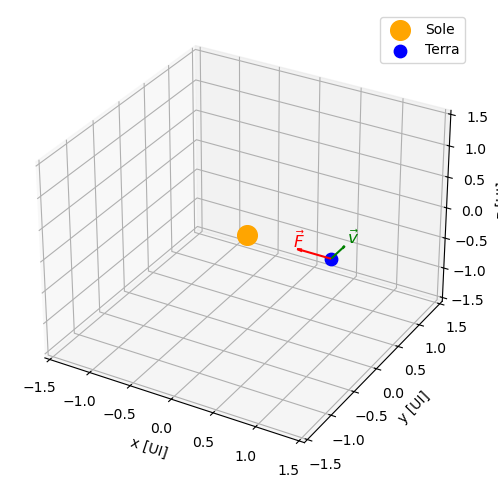

In [5]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

# Corpi
ax.scatter(0,0,0, s=200, c='orange', label='Sole')
ax.scatter(*r0,  s=80,  c='blue',   label='Terra')

def label_vec(ax, x, v, text, color = 'black', offset=0.05):
    p = x + v
    ax.text(*(p + offset*v/np.linalg.norm(v)), text, fontsize=12,color=color)

# Vettori (normalizzati per estetica)
F = g(r0)
v_hat = v0 / np.linalg.norm(v0)
F_hat = F / np.linalg.norm(F)
Lv,LF = 0.3,0.4
ax.quiver(*r0, *v_hat, length=Lv, color='green', arrow_length_ratio=0.15)
ax.quiver(*r0, *F_hat, length=LF, color='red',   arrow_length_ratio=0.15)

# Etichette
label_vec(ax, r0, Lv*v_hat,r"$\vec v$",color='green')
label_vec(ax, r0, LF*F_hat,r"$\vec F$",color='red')

# Layout
L = 1.5
ax.set(xlim=(-L,L), ylim=(-L,L), zlim=(-L,L),
       xlabel='x [UI]', ylabel='y [UI]', zlabel='z [UI]',)
ax.legend()
plt.show()

# Soluzione Euleriana al problema del Moto
Arriviamo ora al cuore del problema: come facciamo a simulare il moto della Terra in questo campo gravitazionale? 
1. La Terra inizialmente si trova nella posizione $\boldsymbol{r}_0$ e ha velocità $\boldsymbol{v}_0$. In questo punto l'accelerazione che subisce è data da $\boldsymbol{g}(\boldsymbol{r}_0)$ 
2. Un istante $dt$ dopo si troverà nella nuova posizione:
    $$\boldsymbol{x}_1 = \boldsymbol{x}_0 + \boldsymbol{v}_0 dt$$
    $$\boldsymbol{v}_1 = \boldsymbol{v}_0 + \boldsymbol{g}(\boldsymbol{r}_0) dt$$
3. Per la posizione è la velocità successiva si ripete lo stesso passaggio, usando $\boldsymbol{x}_1$ e $\boldsymbol{v}_1$ come nuove posizione e velocità iniziale.
Questo metodo di soluzione delle equazioni differenziali si chiama **metodo di Eulero esplicito di ordine 1** ed è l'algoritmo più semplice (e impreciso) possibile.



In [6]:

def evolve(r0,v0,t_end,dt):
    r = [r0]
    v = [v0]
    
    t = [0] 

    pbar = tqdm(total=t_end, unit="time", desc="Evoluzione orbita")
    
    while t[-1] <= t_end:
        # passo di Eulero esplicito
        r_next = r[-1] + v[-1] * dt
        v_next = v[-1] + g(r[-1]) * dt
    
        r.append(r_next)
        v.append(v_next)
    
        # aggiorna il tempo e la barra
        t.append(t[-1]+dt)
        pbar.update(dt)
    
    pbar.close()

    return r,v,t
        

In [7]:
r,v,t = evolve(r0,v0,t_end=12,dt=day_IU);

Evoluzione orbita:   0%|                               | 0/12 [00:00<?, ?time/s]/home/utente/anaconda3/lib/python3.11/site-packages/tqdm/std.py:524: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Evoluzione orbita: 100%|██████| 12.0073536952322/12 [00:00<00:00, 1950.90time/s]


In [13]:
def plot(r, t, t_plot=12, plot3d=True):

    r = np.array(r)
    t = np.array(t)

    # indice massimo corrispondente a t_plot
    idx_max = np.digitize(t_plot, t) - 1
    if idx_max < 1:
        idx_max = 1
    r_plot = r[:idx_max]

    fig = plt.figure(figsize=(7,7))
    if plot3d:
        ax = fig.add_subplot(111, projection='3d')
        ax.plot(r_plot[:,0], r_plot[:,1], r_plot[:,2], color='blue', lw=1.5)
        ax.scatter(r_plot[-1,0], r_plot[-1,1], r_plot[-1,2], color='blue', s=80, label='Terra')
        ax.scatter(0,0,0, color='orange', s=200, label='Sole')
        L = 1.2*np.max(np.linalg.norm(r_plot, axis=1))
        ax.set_xlim([-L,L])
        ax.set_ylim([-L,L])
        ax.set_zlim([-L,L])
        ax.set_zlabel('z [UI]')
        #ax.view_init(elev=25, azim=45)
    else:
        ax = fig.add_subplot(111)
        ax.plot(r_plot[:,0], r_plot[:,1], color='blue', lw=1.5)
        ax.scatter(r_plot[-1,0], r_plot[-1,1], color='blue', s=80, label='Terra')
        ax.scatter(0,0, color='orange', s=200, label='Sole')
        L = 1.2*np.max(np.linalg.norm(r_plot[:,:2], axis=1))
        ax.set_xlim([-L,L])
        ax.set_ylim([-L,L])

    ax.set_xlabel('x [UI]')
    ax.set_ylabel('y [UI]')
    ax.set_title(f"Orbita fino a t = {t_plot:.2f}")
    ax.legend()
    plt.show()

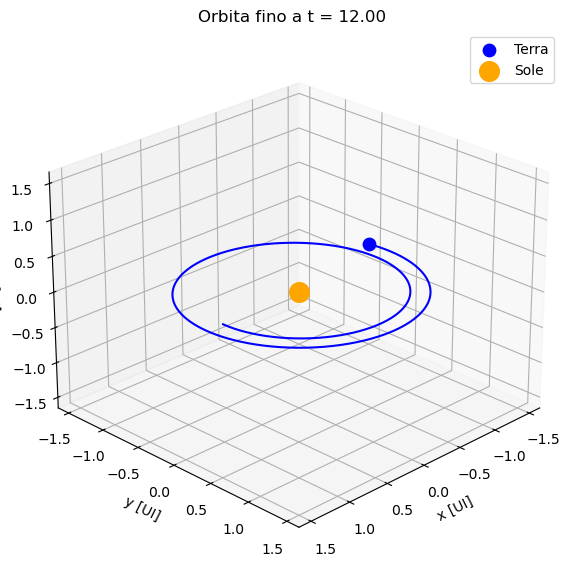

In [9]:
plot(r,t,t_plot=12)

### Cosa succede se inizializziamo v in modo differente da v_c ? 

In [10]:
r0 = np.array([1,0,0])               # VETTORE
v_c = np.sqrt(1/np.linalg.norm(r0))  # Nota: ho usato le unità interne. G=1, M_sun=1
                                     # np.linalg.norm(r) è il modulo del vettore r

# Metà di v_C
v_i = 0.5 * v_c
v0 = np.array([0,v_i,0])             # Nota: v è perpendicolare a r

In [11]:
r,v,t = evolve(r0,v0,t_end=24,dt=0.001*day_IU);

Evoluzione orbita: 100%|██████| 24.000016444611497/24 [00:05<00:00,  4.17time/s]


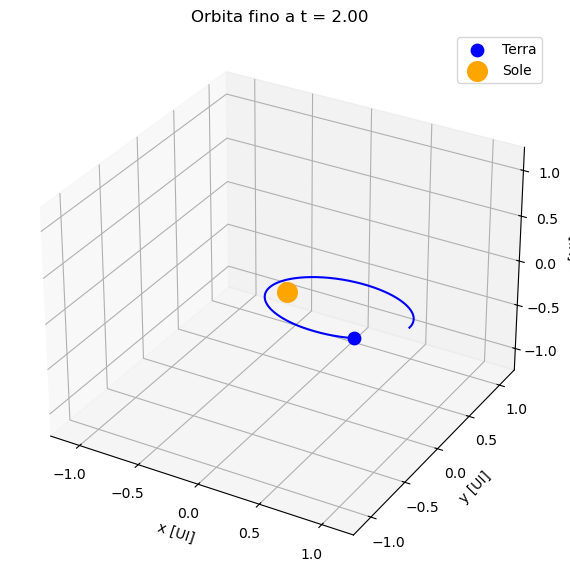

In [14]:
plot(r,t,t_plot=2)


Se $v<v_c$ Terra forma delle **orbite ellittiche**. La posizione iniziale è l'afelio (punto di massimo allontanamento della Terra dal Sole)

In [17]:
r0 = np.array([1,0,0])               # VETTORE
v_c = np.sqrt(1/np.linalg.norm(r0))  # Nota: ho usato le unità interne. G=1, M_sun=1
                                     # np.linalg.norm(r) è il modulo del vettore r

# Doppio di v_C
v_i = 1.1 * v_c
v0 = np.array([0,v_i,0])             # Nota: v è perpendicolare a r

In [16]:
r,v,t = evolve(r0,v0,t_end=24,dt=0.001*day_IU);

Evoluzione orbita: 100%|██████| 24.000016444611497/24 [00:05<00:00,  4.22time/s]


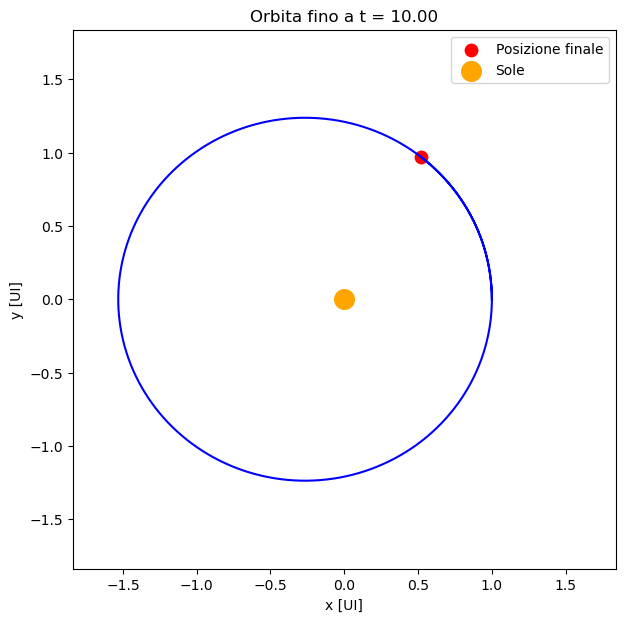

In [35]:
plot(r,t,t_plot=10,plot3d=False)

Se $v>v_c$ la Terra forma delle **orbite ellittiche**, ma adesso la posizione iniziale è il perielio. Cosa succede invece se $v$ equivale alla velocità di fuga: 

$$v_f=\sqrt{\dfrac{2GM_\odot}{r}}$$

In [18]:
r0 = np.array([1,0,0])               # VETTORE
v_f = np.sqrt(2/np.linalg.norm(r0))  # Nota: ho usato le unità interne. G=1, M_sun=1
                                     # np.linalg.norm(r) è il modulo del vettore r

v0 = np.array([0,v_f,0])             # Nota: v è perpendicolare a r

In [19]:
r,v,t = evolve(r0,v0,t_end=24,dt=0.001*day_IU);

Evoluzione orbita: 100%|██████| 24.000016444611497/24 [00:05<00:00,  4.21time/s]


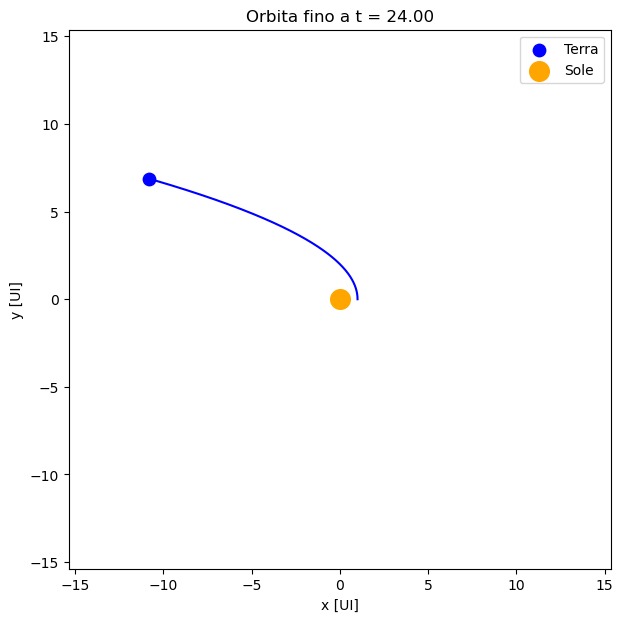

In [21]:
plot(r,t,t_plot=24,plot3d=False)

L'orbita diventa **aperta**. Il caso limite in cui $v=v_f$ corrisponde ad un'orbita parabolica, se $v>v_f$ abbiamo orbite iperboliche.